![](https://storage.googleapis.com/kaggle-datasets-images/1698586/2782287/6b8581c055d5458150d4d1b26c458acb/dataset-cover.jpeg?t=2021-11-06-12-49-50)

https://www.kaggle.com/datasets/karnikakapoor/art-portraits

In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device:{torch.cuda.current_device()}")

print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")
print(f"How many devices {torch.cuda.device_count()}")

True
cuda
Is CUDA supported by this system? True
CUDA version: 12.1
ID of current CUDA device:0
Name of current CUDA device: NVIDIA GeForce RTX 4060
How many devices 1


In [2]:
transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(),
                                ])
y = datasets.ImageFolder('./data/Portraits/', transform=transform)

y_dataloader = torch.utils.data.DataLoader(y,
                                           batch_size=16,
                                           shuffle=False)
y_batched_data = iter(y_dataloader)

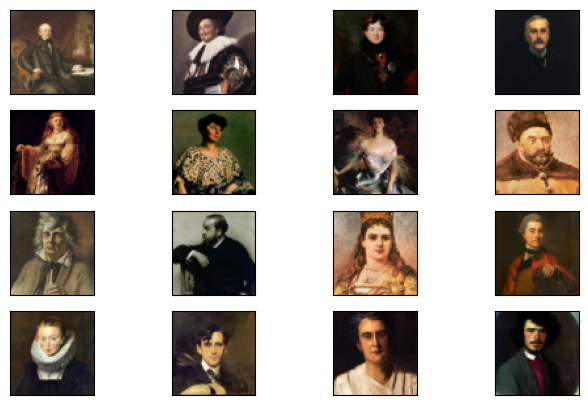

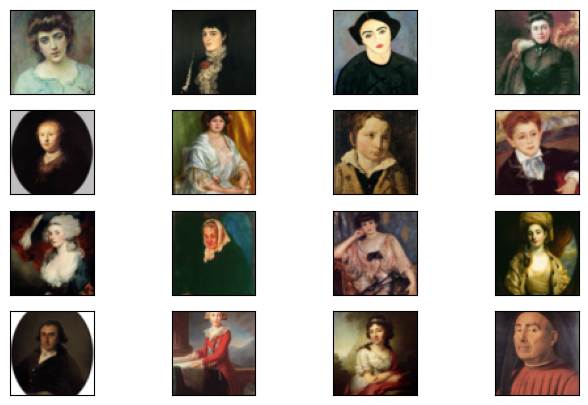

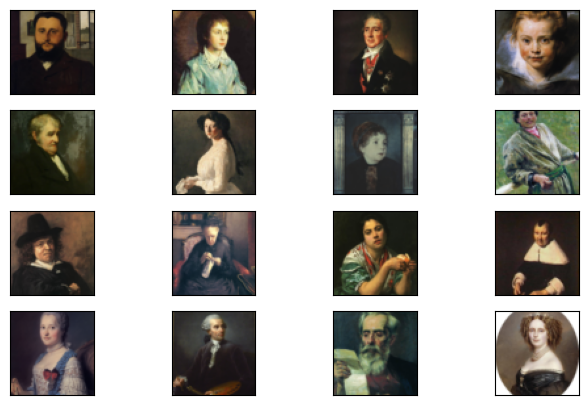

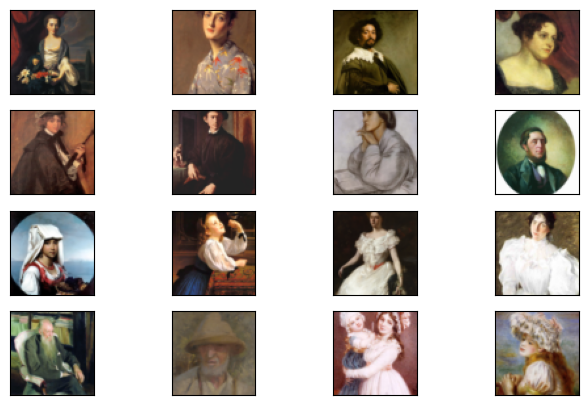

In [3]:
batch = 0
for e, (real, _) in enumerate(y_dataloader):
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 5),  #Размер вывода
                             subplot_kw={'xticks': [], 'yticks': []})
    img_indx = 0
    for i, ax in enumerate(axes):
        for count in range(4):
            ax[count].imshow(real[img_indx].detach().numpy().transpose((1, 2, 0)))
            img_indx += 1
    batch += 1
    if batch == 4:
        break

In [4]:
transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(),
                                #transforms.Grayscale(num_output_channels=1),
                                transforms.Normalize(mean=0.5, std=0.5),
                                ])
y = datasets.ImageFolder('./data/Portraits/', transform=transform)
y_dataloader = torch.utils.data.DataLoader(y,
                                           batch_size=64,
                                           shuffle=False)

In [7]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=100, out_channels=1024, stride=1, kernel_size=4, padding=0, bias=False),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(inplace=True), )

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, stride=2, kernel_size=4, padding=1, bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True), )
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, stride=2, kernel_size=4, padding=1, bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True), )
        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, stride=2, kernel_size=4, padding=1, bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True), )
        self.layer5 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=3, stride=2, kernel_size=4, padding=1, bias=False),
            nn.Tanh())

        # self.fc1 = torch.nn.Linear(512, 1024)
        # self.ac5 = torch.nn.LeakyReLU()
        # self.fc2 = torch.nn.Linear(1024, 2048)
        # self.ac6 = torch.nn.LeakyReLU()
        # self.fc3 = torch.nn.Linear(2048, 3 * 64 * 64)
        # self.ac_end = torch.nn.Sigmoid()

    def forward(self, x):
        x = x.reshape((x.shape[0], x.shape[1], 1, 1))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(-1, 3, 64, 64)
        # x = self.fc1(x)
        # x = self.ac5(x)
        # x = self.fc2(x)
        # x = self.ac6(x)
        # x = self.fc3(x)
        # x = self.ac_end(x)
        # x = x.view(-1, 3, 64, 64)
        return x


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=128, stride=2, kernel_size=5, padding=2, bias=False),
                                    nn.LeakyReLU(0.2, inplace=True),

                                    nn.Conv2d(in_channels=128, out_channels=256, stride=2, kernel_size=5, padding=2, bias=False),
                                    nn.BatchNorm2d(num_features=256),
                                    nn.LeakyReLU(0.2, inplace=True),)
        # nn.BatchNorm1d(512))
        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512, stride=2, kernel_size=5, padding=2, bias=False),
                                    nn.BatchNorm2d(num_features=512),
                                    nn.LeakyReLU(0.2, inplace=True),)
        #nn.BatchNorm1d(128))
        self.output = nn.Sequential( nn.Conv2d(in_channels=512, out_channels=1024, stride=2, kernel_size=5, padding=2, bias=False),
                                     nn.BatchNorm2d(num_features=1024),
                                     nn.LeakyReLU(0.2, inplace=True),

                                     nn.Conv2d(in_channels=1024, out_channels=1, stride=4, kernel_size=5, padding=1, bias=False),
                                     nn.Sigmoid())

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.output(x)
        return x.reshape((x.shape[0], 1))


D = Discriminator().to(device)
I = Generator().to(device)
loss = nn.BCELoss()

D.train()
I.train()

D_optimizer = torch.optim.Adam(D.parameters(), lr=0.0003)  #torch.optim.SGD(D.parameters(), lr=0.003)
I_optimizer = torch.optim.Adam(I.parameters(), lr=0.0003)
for e in range(300):
    for i, (real, _) in enumerate(y_dataloader):
        noise = (torch.rand(real.shape[0],100).to(device) - 0.5) / 0.5
        I_img = I(noise)
        D_I_pred = D(I_img)
        I_loss = loss(D_I_pred, torch.ones_like(D_I_pred))
        I_optimizer.zero_grad()
        I_loss.backward(retain_graph=True)
        I_optimizer.step()

        noise = (torch.rand(real.shape[0],100).to(device) - 0.5) / 0.5
        real = real.to(device)
        I_img = I(noise)
        D_I_pred = D(I_img)
        D_real_pred = D(real)
        D_I_loss = loss(D_I_pred, torch.zeros_like(D_I_pred))
        D_real_loss = loss(D_real_pred, torch.ones_like(D_real_pred))
        D_loss = ((D_I_loss + D_real_loss) / 2).mean()
        D_optimizer.zero_grad()
        D_loss.backward(retain_graph=True)
        D_optimizer.step()

        if i % 100 == 0 or i == len(y_dataloader):
            print('Epoch {} Iteration {}: discriminator_loss {:.3f} generator_loss {:.3f}'.format(e, i, D_loss.item(),
                                                                                                  I_loss.item()))
        print(D_loss.item(), I_loss.item())
    if (e + 1) % 2 == 0:
        torch.save(I, 'Generator_epoch_{}.pth'.format(e))
        print('Model saved.')

Epoch 0 Iteration 0: discriminator_loss 1.846 generator_loss 0.715
1.8461170196533203 0.7147228717803955
0.22449947893619537 16.034509658813477
4.66387414932251 9.699610710144043
0.005155155900865793 14.858467102050781
0.062352318316698074 16.314327239990234
0.13662399351596832 16.076534271240234
0.015817582607269287 14.371031761169434
4.728332996368408 7.526794910430908
0.07564574480056763 11.680002212524414
0.08523574471473694 13.619094848632812
0.07074171304702759 14.210762023925781
0.058509886264801025 14.201545715332031
0.025647679343819618 13.832066535949707
0.030652029439806938 12.962017059326172
0.021907880902290344 11.026676177978516
0.13199645280838013 7.419330596923828
0.07852786034345627 6.923280239105225
0.008678487502038479 8.655259132385254
0.007301604375243187 9.765700340270996
0.006926902569830418 10.149694442749023
0.017982948571443558 10.058055877685547
0.01940818503499031 9.593114852905273
0.012401447631418705 8.52529525756836
0.06248946860432625 6.990755081176758
0

In [8]:
torch.save(I, 'Generator_saved.pth')
torch.save(D, 'Discriminator_saved.pth')

In [ ]:
model = I.cpu()

plt.figure(figsize=(6, 6))
images = torch.rand(1, 3, 64, 64)
plt.tick_params(axis='both', length=0)
plt.axis("off")
plt.imshow(model(images)[0].detach().numpy().transpose((1, 2, 0)))
